In [1]:
# Import necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [2]:
# Import raw train and test data

train_raw = pd.read_csv("./data_folder/train.csv")
test_raw = pd.read_csv("./data_folder/test.csv")

train = train_raw
test = test_raw

ntrain = train.shape[0]
ntest = test.shape[0]

print('The number of rows in the training data:',ntrain)
print('The number of rows in the testing data:',ntest)

The number of rows in the training data: 1460
The number of rows in the testing data: 1459


In [3]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

# Exploratory Data Analysis

We investigated most of the variables individually as well as in relation to the SalePrice however given that there are 79 explanatory variables and we ended up using almost all the explanatory variables in our final model, we decided not to include all these plots. 

# Data cleaning procedure:

Was performed separately for the test and train data as recommended (https://stackoverflow.com/questions/46749037/can-i-use-train-and-test-data-for-imputation) 
<br>

Data cleaning was adapted from the approach used by Serigne. <br> Code available at: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook

The cleaning of the data involved the following steps:

1. Remove the two outliers from the training data as recommended in the data descriptions
2. Log transform the response - SalePrice
3. Rename variable levels that aren't actually missing
4. Impute missing values.

Missing values for numerical variables were imputed using the median, it was also attempted to use MICE (Multiple Imputation by Chained Equations) as an imputation method but given that fewer numerical variables had missing values (than categorical) this did not significantly improve model fit.


# 1. Train data cleaning 

### 1.1 Outlier removal


In [4]:
# Just remove the outlying observations from the training data - as indicated in data description

train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

Check the plots of GrLivArea and OverallQual against SalePrice after removal of outliers:

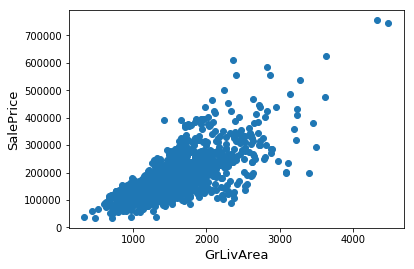

In [5]:
# Check the plot after removal
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

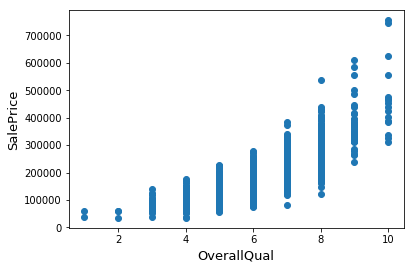

In [6]:
# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['OverallQual'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

### Log transform the response

SalePrice is the variable we need to predict. So we first investigate it's distribution.

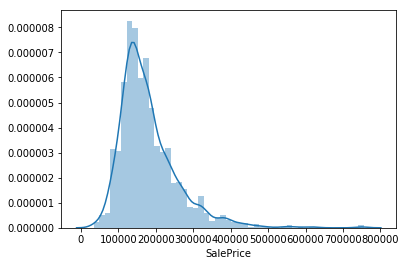

In [7]:
# Look at distribution of response
sns.distplot(train['SalePrice'])

The target variable is right skewed. Since we plan to implement linear regression models, we need to transform this variable and make it more normally distributed.

In [8]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

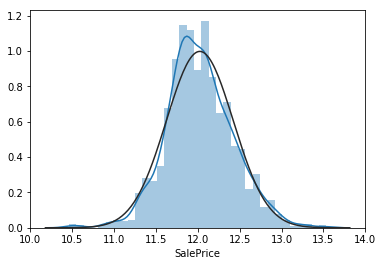

In [9]:
# Check the distribution of the log-transformed response
sns.distplot(train['SalePrice'] , fit=norm);

After the transformation of SalePrice, the skewness seems to have improved and the data appears more normally distributed.

In [10]:
all_data = train    #just to use same term as used in data cleaning source

In [11]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.248
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429


##### Missingness map

In [12]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588
MiscFeature,96.294
Alley,93.754
Fence,80.714
FireplaceQu,47.358
LotFrontage,17.708
GarageYrBlt,5.559
GarageType,5.559
GarageFinish,5.559
GarageQual,5.559


### Renaming NaN levels that aren't truly missing

Some values that are saved as NA, actually have meaning when referenced in the description file. E.g. PoolQC - NaN means No Pool.

In [13]:
train["PoolQC"] = train["PoolQC"].fillna("None")

train["MiscFeature"] = train["MiscFeature"].fillna("None")

train["Alley"] = train["Alley"].fillna("None")

train["Fence"] = train["Fence"].fillna("None")

train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

In [14]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio
LotFrontage,17.708
GarageCond,5.559
GarageQual,5.559
GarageFinish,5.559
GarageYrBlt,5.559
GarageType,5.559
BsmtFinType2,2.608
BsmtExposure,2.608
BsmtFinType1,2.539
BsmtCond,2.539


##### Remove Utilities variable
 For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. Hence we remove it.

In [15]:
train = train.drop(['Utilities'], axis=1)

### Impute missing values

Categorical variables: mode.
Continuous variables: Median or interpreted from data description (e.g. NaN Garage Cars assumed 0 cars)

In [16]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)

for col in ('BsmtFinSF1', "BsmtFinSF2", 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')

train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])

train["Functional"] = train["Functional"].fillna("Typ")

train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])

train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])

train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

# This only matters for the test set - only one value with 150
train.loc[ train['MSSubClass'] == 150, 'MSSubClass'] = 160

In [17]:
#Check remaining missing values if any 
#train_na = (train.isnull().sum() / len(train)) * 100
#train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
#missing_data = pd.DataFrame({'Missing Ratio' :train_na})
#missing_data.head(20)

### None missing

In [18]:
### SAVE FILE TO CSV
train.to_csv('train_clean.csv', sep = ",", index = False)

# 2. Test data cleaning

Just repeating what we did for the train data.

In [19]:
all_data = test    #just to use same term as used in data cleaning source

In [20]:
test["PoolQC"] = test["PoolQC"].fillna("None")

test["MiscFeature"] = test["MiscFeature"].fillna("None")

test["Alley"] = test["Alley"].fillna("None")

test["Fence"] = test["Fence"].fillna("None")

test["FireplaceQu"] = test["FireplaceQu"].fillna("None")

In [21]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :test_na})
missing_data.head(20)

,Missing Ratio
LotFrontage,15.559
GarageQual,5.346
GarageFinish,5.346
GarageYrBlt,5.346
GarageCond,5.346
GarageType,5.209
BsmtCond,3.084
BsmtExposure,3.016
BsmtQual,3.016
BsmtFinType1,2.879


In [22]:
test = test.drop(['Utilities'], axis=1)

In [23]:
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)

for col in ('BsmtFinSF1', "BsmtFinSF2", 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test[col] = test[col].fillna('None')

test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])

test["Functional"] = test["Functional"].fillna("Typ")

test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])

test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])

test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

# This only matters for the test set - only one value with 150
test.loc[ test['MSSubClass'] == 150, 'MSSubClass'] = 160

In [24]:
#Check remaining missing values if any 
#test_na = (test.isnull().sum() / len(test)) * 100
#test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
#missing_data = pd.DataFrame({'Missing Ratio' :test_na})
#missing_data.head(20)
# None missing

In [25]:
### SAVE FILE TO CSV
test.to_csv('test_clean.csv', sep = ",", index = False)

Various online sources were consulted in deciding on modelling approaches, below we have provided links to each of these resources and specifically which sections:

Aleksandrs Gehsbargs (https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force/notebook): <br>
- dealing with nonlinearities through log and square of some predictor variables
- creating the 'TotalSF' variable
- understanding stacking

Mingwei He (https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction/notebook): <br>
- stacking